#### Import Library

In [1]:
import sys
sys.path.append("../modules")
from eda import EDAAnalyzer
from spark_session import SparkManager
from feature_engineering import FeatureEngineer
from pyspark import StorageLevel

In [2]:
# Load autoreload extension
%load_ext autoreload
%autoreload 2

#### Constants and config

In [3]:
mx_submits_path = "../data_sample/mx_submits.parquet/"
mx_submits_line_path = "../data_sample/mx_submitsline.parquet/"


sample_patient_id = "8aad41f612a7095449888c8050abaeb05fdee65643caa3033542610421d8bd1daaa2c4ce1757401003a1bbcd60948a7aa13eba507a676dea80e0cf76b77dbc95"
features_cols = ['secondary_payer_state',
'patient_gender',
'patient_location_residential_region',
'previous_line_level_procedure_ohe']
exclude_cols = ['patient_id']
label_column = 'claim_total_charge_amount'
most_repeated_diagnosis_list = [] 

### Spark Session

In [4]:
mx_submits_spark_manager = SparkManager(mx_submits_path)
mx_submits_line_spark_manager = SparkManager(mx_submits_line_path)

24/10/17 23:19:13 WARN Utils: Your hostname, Chaopings-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 10.0.0.231 instead (on interface en0)
24/10/17 23:19:13 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/17 23:19:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 63220)
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/socketserver.py", line 318, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/socketserver.py", line 349, in process_request
    self.finish_request(reque

### Mx submits

#### EDA

In [5]:
mx_submits_eda = EDAAnalyzer(mx_submits_spark_manager)

In [6]:
mx_submits_eda.display_head()

24/10/17 23:19:15 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,claim_number,cohort_key,cohort_record_id,attending_provider_npi,billing_provider_address_cbsa_name,billing_provider_address_city,billing_provider_address_county,billing_provider_address_key,billing_provider_address_latitude,billing_provider_address_longitude,...,type_of_bill_frequency_description,vendorname,cycle_id,patient_birth_year,patient_gender,patient_id,patient_location_preferred_latitude,patient_location_preferred_longitude,patient_location_preferred_zipcode,patient_location_preferred_type
0,d15bd78f4275d493fa9c2d862fb24863,767ef4cac69e8a0c77384f6e1414364b,6645d6e8ede891a875ae96bc91188fa5,None,"MIAMI-FORT LAUDERDALE-POMPANO BEACH, FL",Pembroke Pines,Broward,703NFLAMINGORDPEMBROKEPINESFL33028,26.012682,-80.310287,...,None,cyan,full_20240611,2016,F,cbed99ab51c5c26aadb1c69fef5cb48e15be94c0c16004...,26.012682,-80.310287,33026,1
1,135e6c968a8d39fc4c406d5c51a02f1e,0e6b9e4a0d9103c5a9c4f1332d38ef53,8080db10ebbe9960957f86b4c1e32c74,None,"MIAMI-FORT LAUDERDALE-POMPANO BEACH, FL",Miami,Miami-Dade,2600SDOUGLASRDMIAMIFL33134,25.742325,-80.254471,...,Admit Through Discharge Claim,cyan,full_20240611,1964,F,64bf25c773a8078105e391d5074923304156b5dc6460a3...,28.05644,-82.451753,33612,1
2,c8e11f355938d80212d189e9a0d0d7dc,f74909ace68e51891440e4da0b65a70c,9daf9e9e56d51c24c3cce85e815cdba6,None,"VINCENNES, IN",Vincennes,Knox,1160ESAINTCLAIRSTVINCENNESIN47591,38.680187,-87.510361,...,None,cyan,full_20240611,1963,F,d5f343e39f9abc8e1745ca0aecea3d36767894f91b642d...,38.242580,-87.513318,47648,2
3,f355cc2efcb05a35300b17d9d21d0c48,f74909ace68e51891440e4da0b65a70c,e9927f4874d77b12e469424fb2ff2b44,1790224699,None,None,None,None,None,None,...,Admit Through Discharge Claim,cyan,full_20240611,1932,M,fc5cd962003e6f173cf70c2d1917a5cc163823d6dd9be8...,35.170105,-89.751358,38016,1
4,5b2f2a5f5145af513cf79e43c36053ef,0e6b9e4a0d9103c5a9c4f1332d38ef53,9f35dd46aeed03cf4017e0cb9b0d93ee,None,"BALTIMORE-COLUMBIA-TOWSON, MD",Rosedale,Baltimore,9000FRANKLINSQUAREDRROSEDALEMD21237,39.351406,-76.480293,...,Admit Through Discharge Claim,cyan,full_20240611,1986,F,d29bb1d24b6ad3d5ca22c0f74f36d069119228227e8e02...,39.287311,-76.491821,21224,1


In [7]:
mx_submits_eda.display_shape()

'Shape of data: rows: 124217, cols: 127'

#### Type conversion

In [8]:
mx_submits_eda.convert_columns_to_float(["claim_total_charge_amount"])

Casted claim_total_charge_amount to float


column_info_submits = mx_submits_eda.display_column_info()
column_info_submits.to_csv("../output/column_info_submits.csv")
column_info_submits

column_info_submits[column_info_submits["Column Name"]=="claim_total_charge_amount"]

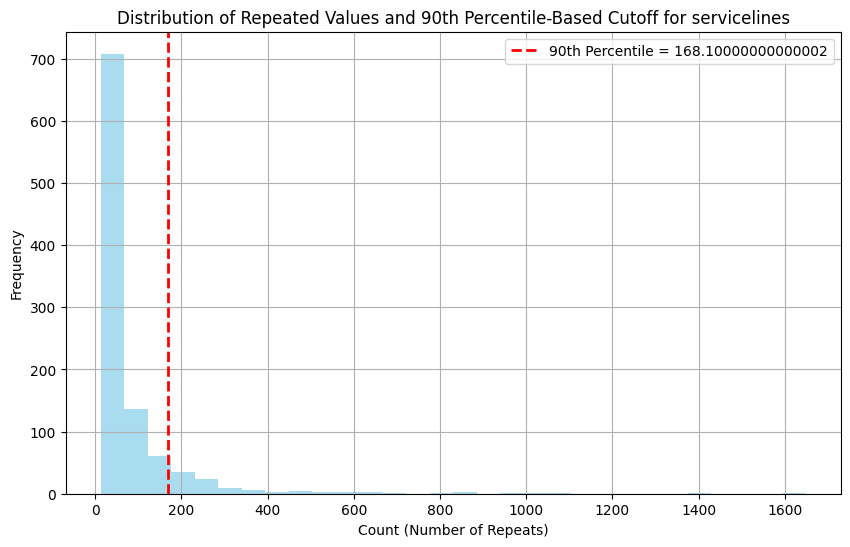

In [9]:
mx_submits_eda.plot_percentile_based_procedure_cutoff("servicelines",90, per_patient= True)

In [10]:
mx_submits_line_level_procedure_codes_repeat_count = mx_submits_eda.get_top_n_repeated_procedures_unique_per_patient("servicelines")

In [11]:
mx_submits_line_level_procedure_codes_repeat_count

,line_level_procedure_code,count,line_level_procedure_code_length
0,99213,1648,5.0
1,99214,1381,5.0
2,99203,1100,5.0
3,36415,1010,5.0
4,85025,952,5.0
...,...,...,...
5611,67500,1,5.0
5612,93662,1,5.0
5613,A9558,1,5.0
5614,95970,1,5.0


In [12]:
most_repeated_procedures = mx_submits_line_level_procedure_codes_repeat_count[
    (mx_submits_line_level_procedure_codes_repeat_count["count"] > 168) &
    (mx_submits_line_level_procedure_codes_repeat_count["line_level_procedure_code"].notna()) 
]
most_repeated_procedure_list = most_repeated_procedures['line_level_procedure_code'].tolist()
most_repeated_procedures

,line_level_procedure_code,count,line_level_procedure_code_length
0,99213,1648,5.0
1,99214,1381,5.0
2,99203,1100,5.0
3,36415,1010,5.0
4,85025,952,5.0
...,...,...,...
95,G0008,175,5.0
96,99238,175,5.0
97,96375,175,5.0
98,J2704,170,5.0


In [13]:
most_repeated_procedure_list

['99213',
 '99214',
 '99203',
 '36415',
 '85025',
 '99204',
 '80053',
 '99284',
 '80061',
 '99212',
 '99285',
 '90471',
 '99283',
 '84443',
 '88305',
 '83036',
 '81001',
 '81003',
 '93010',
 '80048',
 '99202',
 '97110',
 'A0425',
 '87880',
 '93000',
 '71046',
 '90686',
 '96372',
 '82306',
 '93005',
 'U0003',
 '97140',
 '85027',
 '99215',
 '87086',
 '99232',
 '99396',
 '81002',
 '93306',
 'J2405',
 '92014',
 '71045',
 '87804',
 '70450',
 '84439',
 '85610',
 '3078F',
 '92015',
 'J1100',
 '90715',
 '3074F',
 '87491',
 '99395',
 '99223',
 'A0427',
 '87591',
 '71020',
 '81025',
 '83690',
 '84484',
 '90460',
 '82607',
 '99211',
 '96374',
 'J3010',
 '83735',
 '97530',
 'Q9967',
 '77067',
 'G8427',
 'J1885',
 '99233',
 '74177',
 '80050',
 '3008F',
 'U0005',
 '92004',
 '99205',
 '97161',
 '90791',
 '77063',
 '1036F',
 '97112',
 '87426',
 '73630',
 '90670',
 '43239',
 '99000',
 '85730',
 'J2250',
 '99222',
 '88175',
 '87635',
 '73030',
 'G0008',
 '99238',
 '96375',
 'J2704',
 '99239']

#### Feature Engineering

In [14]:
mx_submits_fe=FeatureEngineer(mx_submits_spark_manager)

In [15]:
mx_submits_fe.transform_line_level_procedure_codes()

,line_level_procedures_ohe
0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [16]:
mx_submits_fe.add_procedures_with_exponential_decay_sparse_vector()

,previous_line_level_procedure_ohe
0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [17]:
 mx_submits_fe.remove_procedure_codes(most_repeated_procedure_list)

DataFrame After Removing Procedure Codes - Shape: 79740 rows, 132 columns


In [18]:
# mx_submits_fe.add_continuous_visit_years()
# mx_submits_fe.display_top_rows_as_pandas("continuous_visit_years")

In [19]:
mx_submits_fe.retain_columns(features_cols)

In [20]:
mx_submits_fe.convert_columns_to_float(["claim_total_charge_amount"])

Casted claim_total_charge_amount to float


In [21]:
preprocess_data = mx_submits_fe.preprocess_procedure_data(exclude_cols=exclude_cols)
preprocess_data

One-Hot Encoding applied successfully to column: secondary_payer_state
One-Hot Encoding applied successfully to column: facility_provider_address_region
One-Hot Encoding applied successfully to column: patient_gender
One-Hot Encoding applied successfully to column: patient_location_residential_region
One-Hot Encoding applied successfully to column: principal_diagnosis_body_part
One-Hot Encoding applied successfully to column: principal_diagnosis_category
Assembling all features into a vector with 8 columns.


Preprocessing complete. Feature vector created.


In [22]:
columns_df = mx_submits_fe.get_columns_as_pandas_df()
columns_df['Column Names'].to_list()
feature_cols = mx_submits_fe.get_feature_columns()
feature_cols

['secondary_payer_state_ohe',
 'facility_provider_address_region_ohe',
 'patient_gender_ohe',
 'patient_location_residential_region_ohe',
 'principal_diagnosis_body_part_ohe',
 'principal_diagnosis_category_ohe',
 'claim_total_charge_amount',
 'previous_line_level_procedure_ohe']

In [23]:
mx_submits_fe.dataframe.persist(StorageLevel.MEMORY_AND_DISK)

DataFrame[secondary_payer_state: string, facility_provider_address_region: string, patient_gender: string, patient_location_residential_region: string, principal_diagnosis_body_part: string, principal_diagnosis_category: string, claim_all_diagnosis_codes: array<struct<diagnosis_code_set:string,diagnosis_code:string,diagnosis_pointer:string>>, claim_total_charge_amount: float, previous_line_level_procedure_ohe: vector, secondary_payer_state_index: double, facility_provider_address_region_index: double, patient_gender_index: double, patient_location_residential_region_index: double, principal_diagnosis_body_part_index: double, principal_diagnosis_category_index: double, secondary_payer_state_ohe: vector, facility_provider_address_region_ohe: vector, patient_gender_ohe: vector, patient_location_residential_region_ohe: vector, principal_diagnosis_body_part_ohe: vector, principal_diagnosis_category_ohe: vector, features: vector]

In [24]:
#mx_submits_fe.reduce_dataframe_size()
mx_submits_fe.train_autoencoder(10)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


24/10/17 23:47:32 WARN CacheManager: Asked to cache already cached data.


Approximate distinct count: 79740
Steps per epoch: 311


2024-10-17 23:50:51.508193: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


Epoch 1/10
311/311 - 12s - 38ms/step - loss: 0.3001
Epoch 2/10
311/311 - 12s - 38ms/step - loss: 0.2956
Epoch 3/10
311/311 - 12s - 40ms/step - loss: 0.2960
Epoch 4/10
311/311 - 12s - 39ms/step - loss: 0.2958
Epoch 5/10
311/311 - 12s - 39ms/step - loss: 0.2955
Epoch 6/10
311/311 - 12s - 39ms/step - loss: 0.2955
Epoch 7/10
311/311 - 12s - 38ms/step - loss: 0.2960
Epoch 8/10
311/311 - 11s - 36ms/step - loss: 0.2961
Epoch 9/10
311/311 - 12s - 37ms/step - loss: 0.2956
Epoch 10/10
311/311 - 11s - 37ms/step - loss: 0.2947


2024-10-17 23:52:50.191131: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: CANCELLED: GetNextFromShard was cancelled
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


In [25]:
#mx_submits_fe.save_autoencoder("../output/model")

In [26]:
#mx_submits_fe.load_autoencoder("../output/model")

In [27]:
mx_submits_fe.create_procedure_feature_name_map()

In [28]:
feature_impact = mx_submits_fe.evaluate_feature_impact()
feature_impact

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


2024-10-17 23:52:50.445754: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-10-17 23:52:50.452524: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-10-17 23:52:50.616399: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

2024-10-17 23:52:50.899641: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


,Feature Index,Impact,Feature Name
0,0,0.140007,claim_total_charge_amount
1,53,0.136336,line_level_procedure_27447
2,44,0.133998,line_level_procedure_72070
3,39,0.130532,line_level_procedure_B4152
4,45,0.121880,line_level_procedure_33208
...,...,...,...
5719,4607,0.000507,line_level_procedure_00702
5720,5163,0.000505,line_level_procedure_15275
5721,3333,0.000500,line_level_procedure_84228
5722,3292,0.000496,line_level_procedure_3EC21


In [31]:
feature_impact["Feature Name"].to_list()[:302]

['claim_total_charge_amount',
 'line_level_procedure_27447',
 'line_level_procedure_72070',
 'line_level_procedure_B4152',
 'line_level_procedure_33208',
 'line_level_procedure_1123F',
 'line_level_procedure_J1094',
 'line_level_procedure_95117',
 'line_level_procedure_A4332',
 'line_level_procedure_72100',
 'line_level_procedure_84100',
 'line_level_procedure_99243',
 'line_level_procedure_97014',
 'line_level_procedure_T1015',
 'line_level_procedure_J1644',
 'line_level_procedure_74360',
 'line_level_procedure_D0274',
 'line_level_procedure_92002',
 'line_level_procedure_97153',
 'line_level_procedure_83002',
 'line_level_procedure_82435',
 'line_level_procedure_84132',
 'line_level_procedure_84479',
 'line_level_procedure_84439',
 'line_level_procedure_99214',
 'line_level_procedure_0241U',
 'line_level_procedure_U0003',
 'line_level_procedure_T4522',
 'line_level_procedure_84153',
 'line_level_procedure_74177',
 'line_level_procedure_99285',
 'line_level_procedure_51702',
 'line_le

In [30]:
# mx_submits_fe.retain_columns(features_cols+[label_column])